In [26]:
import pandas as pd
import glob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import matplotlib

In [71]:
csv_files = glob.glob("./CleanedCommentsV3/*.csv")
dfs = []

In [72]:
for csv_file in csv_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file, sep=';')
    # Append the DataFrame to the list
    dfs.append(df)

In [73]:
dataset = pd.concat(dfs, ignore_index=True)

In [30]:
dataset.head()

,id,name,text,time,likes,reply,CleanedText,ProcessText,SentimentScore,ActualLabel
0,UCizlqA8o4_mqMWNxDdqRcXQ,@KatharineOsborne,As a software developer who has been unemploye...,2024-03-07T14:56:37Z,566,NaN,As a software developer who has been unemploye...,software developer unemployed last month never...,-0.243,Negative
1,UCSYHnMrlfigBMF7Vay1Vsrw,@pilotheress,we are getting very close to the time the grea...,2024-03-09T23:43:39Z,429,NaN,We are getting very close to the time the grea...,get close time great depression start year ago...,-0.430,Negative
2,UCziXginurkiaPoc-8iGtMlQ,@coquifrog,"Yup, I chose software six years ago for job se...",2024-03-12T12:41:08Z,89,UCizlqA8o4_mqMWNxDdqRcXQ,"Yup, I chose software six years ago for job se...",yup choose software year ago job security job ...,-0.311,Negative
3,UCyNz6601vEJZ3AErVi9Zlrw,@victor-536,So are kindergarten and elementary school teac...,2024-03-12T09:59:23Z,81,UCU78zKig96wgiyirg8wxUaQ,So are kindergarten and elementary school teac...,kindergarten elementary school teacher go leav...,-0.464,Negative
4,UCZw-DUPQxMPBgsADukzqO3Q,@MarinaMarina-fr8ex,The problem right now is not in AI but in econ...,2024-03-12T16:36:39Z,46,UCizlqA8o4_mqMWNxDdqRcXQ,The problem right now is not in AI but in econ...,problem right not ai economics crisis big guy ...,-0.544,Negative


In [31]:
dataset.count()

id                5519
name              5518
text              5518
time              5519
likes             5519
reply             1049
CleanedText       5478
ProcessText       5447
SentimentScore    5519
ActualLabel       5519
dtype: int64

In [32]:
# Remove rows where the content of the "CleanedText" column is NaN, empty, or has the number 0
dataset = dataset.dropna(subset=['ProcessText'])
dataset = dataset.dropna(subset=['ActualLabel'])
dataset = dataset[
    (dataset['CleanedText'] != '') &
    (dataset['CleanedText'] != '0') &
    (dataset['ActualLabel'] != 'N/A') &
    (dataset['ActualLabel'] != 'Proof?') &
    (~dataset['CleanedText'].str.contains('tina', case=False, na=False)) &
    (~dataset['CleanedText'].str.contains('Tina', case=False, na=False))
]


# Reset the index after removing rows
dataset.reset_index(drop=True, inplace=True)

In [33]:
dataset.count()

id                5433
name              5432
text              5433
time              5433
likes             5433
reply             1016
CleanedText       5433
ProcessText       5433
SentimentScore    5433
ActualLabel       5433
dtype: int64

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from scipy.stats import uniform

In [35]:
negative_sample = dataset[dataset['ActualLabel'] == 'Negative'].sample(n=3771, random_state=42)
dataset = dataset.drop(negative_sample.index)

In [36]:
print(dataset['ActualLabel'].value_counts())

ActualLabel
Negative    831
Positive    831
Name: count, dtype: int64


In [37]:
X = dataset[['ProcessText']]  # The textprocessed (tokenized and lemmatized) text column
y = dataset[['ActualLabel']]  # The true sentiment label column

In [38]:
y.value_counts()

ActualLabel
Negative       831
Positive       831
Name: count, dtype: int64

<Axes: ylabel='count'>

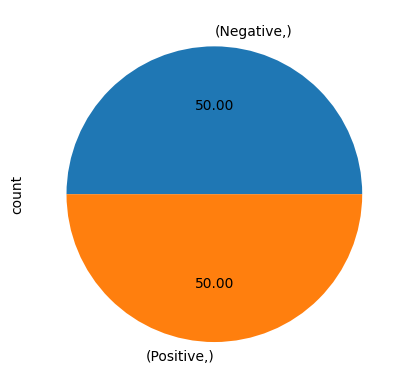

In [39]:
y.value_counts().plot.pie(autopct='%0.2f')

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [41]:
X_train.count()

ProcessText    1163
dtype: int64

In [42]:
X_test.count()

ProcessText    499
dtype: int64

In [43]:
y_train.value_counts()

ActualLabel
Positive       584
Negative       579
Name: count, dtype: int64

In [44]:
# Fit the TfidfVectorizer to determine the number of features
tfidf_vectorizer = TfidfVectorizer(min_df=1)
X_train = X_train.squeeze()
X_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Determine the number of features
num_features = X_tfidf.shape[1]

# Set 'k' to the minimum of 700 or the number of features
k_best = min(1000, num_features)

#select_k_best = SelectKBest(chi2, k=k_best)

In [45]:
num_features = X_tfidf.shape[1]
print(f"Number of features after applying min_df: {num_features}")

Number of features after applying min_df: 3172


In [46]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('chi2', SelectKBest(chi2, k=k_best)),  # k is the number of features to select
    ('nb', MultinomialNB())
])

In [47]:
param_grid = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    # Add or remove ngram ranges as needed
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
    # Adjust the range of 'k' values based on your dataset and feature importance
    'tfidf__use_idf': [True, False],
    'tfidf__smooth_idf': [True, False],
    'tfidf__sublinear_tf': [True, False],
    'chi2__k': [50, 100, 300, 500, 700, 1000],
    'nb__alpha': [0.01, 0.1, 0.5, 1, 2],
    'nb__fit_prior': [True, False],
    'nb__class_prior': [None, [0.5, 0.5]]  # Example for balanced classes
}

In [51]:
X_train = X_train.squeeze()
y_train = y_train.squeeze()

In [24]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y_train)

In [25]:
# Define GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_parameters}")
print(f"Best Score: {best_score}")

KeyboardInterrupt: 

In [48]:
# Current Setup
pipeline.set_params(
    chi2__k=1000,  
    nb__alpha=2,  
    nb__class_prior=None,
    nb__fit_prior=True,  
    tfidf__max_df=0.5,  
    tfidf__ngram_range=(1, 1),  
    tfidf__smooth_idf=False,  
    tfidf__sublinear_tf=False,  
    tfidf__use_idf=True  
)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.5, smooth_idf=False)),
                ('chi2',
                 SelectKBest(k=1000,
                             score_func=<function chi2 at 0x000001B458FC8AE0>)),
                ('nb', MultinomialNB(alpha=2))])

Using V3 Comments

In [52]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.5, smooth_idf=False)),
                ('chi2',
                 SelectKBest(k=1000,
                             score_func=<function chi2 at 0x000001B458FC8AE0>)),
                ('nb', MultinomialNB(alpha=2))])

In [53]:
X_test = X_test.squeeze()

In [54]:
y_pred = pipeline.predict(X_test)

In [55]:
y_pred

array(['Positive', 'Positive', 'Positive', 'Positive', 'Negative',
       'Negative', 'Negative', 'Positive', 'Negative', 'Positive',
       'Negative', 'Positive', 'Negative', 'Negative', 'Positive',
       'Positive', 'Negative', 'Negative', 'Negative', 'Negative',
       'Positive', 'Negative', 'Negative', 'Negative', 'Negative',
       'Negative', 'Negative', 'Negative', 'Positive', 'Negative',
       'Negative', 'Negative', 'Positive', 'Negative', 'Negative',
       'Negative', 'Negative', 'Positive', 'Negative', 'Positive',
       'Negative', 'Negative', 'Positive', 'Negative', 'Negative',
       'Negative', 'Positive', 'Negative', 'Positive', 'Negative',
       'Positive', 'Positive', 'Positive', 'Negative', 'Positive',
       'Positive', 'Negative', 'Positive', 'Negative', 'Negative',
       'Positive', 'Negative', 'Negative', 'Negative', 'Positive',
       'Positive', 'Negative', 'Negative', 'Negative', 'Positive',
       'Negative', 'Positive', 'Positive', 'Positive', 'Negati

In [56]:
from collections import Counter

# Assuming y_pred is your array of predictions
label_counts = Counter(y_pred)

# To display the count of each unique label
for label, count in label_counts.items():
    print(f'Label: {label}, Count: {count}')

Label: Positive, Count: 219
Label: Negative, Count: 280


In [57]:
# Access the TF-IDF Vectorizer step
tfidf_vectorizer = pipeline.named_steps['tfidf']
# Get the feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Access the SelectKBest step
chi2_selector = pipeline.named_steps['chi2']
# Get the scores and p-values
chi2_scores = chi2_selector.scores_
chi2_pvalues = chi2_selector.pvalues_

# Get the indices of the selected features
selected_indices = chi2_selector.get_support(indices=True)
# Get the names of the selected features
selected_features = feature_names[selected_indices]

In [58]:
feature_scores = pd.DataFrame({
    'Feature': selected_features,
    'Score': chi2_scores[selected_indices],
    'P-value': chi2_pvalues[selected_indices]
}).sort_values(by='Score', ascending=False)

In [59]:
tfidf_matrix = tfidf_vectorizer.transform(X_train)
average_tfidf_scores = tfidf_matrix.mean(axis=0).A1  # A1 flattens the array
tfidf_feature_scores = pd.DataFrame({
    'Feature': feature_names,
    'Average TF-IDF Score': average_tfidf_scores
}).sort_values(by='Average TF-IDF Score', ascending=False)

In [65]:
# Get the top 20 features
top_20_feature_scores = feature_scores.head(20)

# Print the top 20 features
print(top_20_feature_scores)

       Feature      Score   P-value
892      thank  16.263122  0.000055
894     thanks  13.684697  0.000216
637        not  10.446842  0.001229
402      great   9.409716  0.002158
679     people   8.101944  0.004422
559       love   7.903372  0.004934
508        job   7.769024  0.005315
558       loud   7.352253  0.006698
395       good   7.016084  0.008078
77     awesome   5.588790  0.018076
953      video   5.119630  0.023657
751    replace   4.672581  0.030648
18          ai   4.577574  0.032393
31       amaze   4.336424  0.037305
565        man   4.259412  0.039033
420     happen   3.991860  0.045721
527      laugh   3.802030  0.051190
611       mosh   3.793009  0.051467
307  excellent   3.743547  0.053012
393         go   3.584089  0.058335


In [64]:
# Get the top 20 features
top_20_features = tfidf_feature_scores.head(2)

# Print the top 20 features
print(top_20_features)

      Feature  Average TF-IDF Score
86         ai              0.042812
1941      not              0.030444
1560      job              0.029561
1257     good              0.018005
2073   people              0.016976
1251       go              0.016893
3040    video              0.016765
2832    thank              0.015415
2373  replace              0.014621
2834   thanks              0.014516
1723     make              0.014360
1273    great              0.013179
2787     take              0.012538
1902     need              0.012345
1395    human              0.012331
3090     well              0.011847
1232      get              0.011729
3153     year              0.011380
1699     loud              0.011123
3123     work              0.010510


In [60]:
print(tfidf_feature_scores)

          Feature  Average TF-IDF Score
86             ai              0.042812
1941          not              0.030444
1560          job              0.029561
1257         good              0.018005
2073       people              0.016976
...           ...                   ...
863           duo              0.000044
1743        maria              0.000044
774     destefano              0.000044
1511      interim              0.000044
754   democratize              0.000044

[3172 rows x 2 columns]


In [61]:
# Removing Certain Amount of Negative Comments to Make the Sentiment Count Balance
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

    Negative       0.71      0.79      0.74       252
    Positive       0.75      0.67      0.71       247

    accuracy                           0.73       499
   macro avg       0.73      0.73      0.73       499
weighted avg       0.73      0.73      0.73       499



In [66]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1662, 1)
y shape: (1662, 1)


In [68]:
X = X.squeeze()
y = y.squeeze()

In [69]:
scores = cross_val_score(pipeline, X, y, cv=10)

In [70]:
print("Cross-validation scores for each fold:")
print(scores)

print("Average 10 fold cross-validation score:")
print(scores.mean())

Cross-validation scores for each fold:
[0.68862275 0.68862275 0.73493976 0.74096386 0.73493976 0.77108434
 0.78313253 0.71084337 0.68674699 0.71686747]
Average 10 fold cross-validation score:
0.7256763581271193
